<a href="https://colab.research.google.com/github/Keisuke-Miyata/Flower102_Classification_mini/blob/main/ML_notebooks/Flower102_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Getting setup

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
!pip install torchinfo
from torchinfo import summary
from torchvision.transforms import ToTensor
from torchvision import transforms
from torch import nn

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Setting up functions

In [3]:
import os

os.makedirs("modular", exist_ok=True)

In [4]:
%%writefile modular/data_setup.py
"""
Contains functionality for creating PyTorch DataLoaders for
image classification data.
"""
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):
  """Creates training and testing DataLoaders.

  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """
  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False, # don't need to shuffle test data
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

Writing modular/data_setup.py


In [5]:
%%writefile modular/engine.py
"""
Contains functions for training and testing a PyTorch model.
"""
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
  """
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item()

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
  """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]}
    For example if training for epochs=2:
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]}
  """
  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  # Return the filled results at the end of the epochs
  return results

Writing modular/engine.py


In [6]:
%%writefile modular/helper.py

from typing import Dict, List
from matplotlib import pyplot as plt


def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

Writing modular/helper.py


In [7]:
%%writefile modular/utils.py
"""
Contains various utility functions for PyTorch model training and saving.
"""
import torch
from pathlib import Path

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
  """Saves a PyTorch model to a target directory.

  Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.

  Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="pretrained_vit_feature_extractor_3_types_of_flowers.pth")
  """
  # Create target directory
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)

  # Create model save path
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path / model_name

  # Save the model state_dict()
  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)


import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict
import torchvision.transforms as transforms



  # 1. Create a function to return a list of dictionaries with sample, truth label, prediction, prediction probability and prediction time
def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: transforms.Compose,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:

    # 2. Create an empty list to store prediction dictionaries
    pred_list = []

    # 3. Loop through target paths
    for path in tqdm(paths):

        # 4. Create empty dictionary to store prediction information for each sample
        pred_dict = {}

        # 5. Get the sample path and ground truth class name
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        # 6. Start the prediction timer
        start_time = timer()

        # 7. Open image path
        img = Image.open(path)

        # 8. Transform the image, add batch dimension and put image on target device
        transformed_image = transform(img).unsqueeze(0).to(device)

        # 9. Prepare model for inference by sending it to target device and turning on eval() mode
        model.to(device)
        model.eval()

        # 10. Get prediction probability, predicition label and prediction class
        with torch.inference_mode():
            pred_logit = model(transformed_image) # perform inference on target sample
            pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
            pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label
            pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU

            # 11. Make sure things in the dictionary are on CPU (required for inspecting predictions later on)
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class

            # 12. End the timer and calculate time per pred
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        # 13. Does the pred match the true label?
        pred_dict["correct"] = class_name == pred_class

        # 14. Add the dictionary to the list of preds
        pred_list.append(pred_dict)

    # 15. Return list of prediction dictionaries
    return pred_list

Writing modular/utils.py


In [8]:
# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

In [9]:
classes = [
        "pink primrose",
        "hard-leaved pocket orchid",
        "canterbury bells",
        "sweet pea",
        "english marigold",
        "tiger lily",
        "moon orchid",
        "bird of paradise",
        "monkshood",
        "globe thistle",
        "snapdragon",
        "colt's foot",
        "king protea",
        "spear thistle",
        "yellow iris",
        "globe-flower",
        "purple coneflower",
        "peruvian lily",
        "balloon flower",
        "giant white arum lily",
        "fire lily",
        "pincushion flower",
        "fritillary",
        "red ginger",
        "grape hyacinth",
        "corn poppy",
        "prince of wales feathers",
        "stemless gentian",
        "artichoke",
        "sweet william",
        "carnation",
        "garden phlox",
        "love in the mist",
        "mexican aster",
        "alpine sea holly",
        "ruby-lipped cattleya",
        "cape flower",
        "great masterwort",
        "siam tulip",
        "lenten rose",
        "barbeton daisy",
        "daffodil",
        "sword lily",
        "poinsettia",
        "bolero deep blue",
        "wallflower",
        "marigold",
        "buttercup",
        "oxeye daisy",
        "common dandelion",
        "petunia",
        "wild pansy",
        "primula",
        "sunflower",
        "pelargonium",
        "bishop of llandaff",
        "gaura",
        "geranium",
        "orange dahlia",
        "pink-yellow dahlia?",
        "cautleya spicata",
        "japanese anemone",
        "black-eyed susan",
        "silverbush",
        "californian poppy",
        "osteospermum",
        "spring crocus",
        "bearded iris",
        "windflower",
        "tree poppy",
        "gazania",
        "azalea",
        "water lily",
        "rose",
        "thorn apple",
        "morning glory",
        "passion flower",
        "lotus",
        "toad lily",
        "anthurium",
        "frangipani",
        "clematis",
        "hibiscus",
        "columbine",
        "desert-rose",
        "tree mallow",
        "magnolia",
        "cyclamen",
        "watercress",
        "canna lily",
        "hippeastrum",
        "bee balm",
        "ball moss",
        "foxglove",
        "bougainvillea",
        "camellia",
        "mallow",
        "mexican petunia",
        "bromelia",
        "blanket flower",
        "trumpet creeper",
        "blackberry lily",
    ]

class_to_idx = {name: i for i, name in enumerate(classes)}


## 2. Getting data

In [10]:
import os
import torch
import random
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Subset
from PIL import Image

# Specify dataset root
dataset_root = "data"

# Load datasets
full_train_data = datasets.Flowers102(root=dataset_root, split="train", download=True, transform=ToTensor())
full_test_data = datasets.Flowers102(root=dataset_root, split="test", download=True, transform=ToTensor())



# Define the classes
selected_classes = ["pink primrose", "hard-leaved pocket orchid", "canterbury bells"]

# Get the class-to-index mapping
print(class_to_idx)
selected_class_indices = [class_to_idx[cls] for cls in selected_classes]



# Get indices of images belonging to the selected classes
train_indices = [i for i, (_, label) in enumerate(full_train_data) if label in selected_class_indices]
test_indices = [i for i, (_, label) in enumerate(full_test_data) if label in selected_class_indices]


# Function to select only a small set of the images per class: default is 10%
def select_subset(indices, dataset, percentage=0.1):
    class_dict = {cls: [] for cls in selected_class_indices}

    # Group images by class
    for i in indices:
        _, label = dataset[i]
        class_dict[label].append(i)

    # Randomly select 10% from each class
    subset_indices = []
    for label, img_indices in class_dict.items():
        num_samples = max(1, int(len(img_indices) * percentage))  # At least 1 sample per class
        subset_indices.extend(random.sample(img_indices, num_samples))

    return Subset(dataset, subset_indices)


# Function to save images
def save_images(dataset, dataset_type, target_dir):
    for i, (image_tensor, label) in enumerate(dataset):
        # Convert tensor to PIL image
        image = Image.fromarray((image_tensor.permute(1, 2, 0).numpy() * 255).astype("uint8"))

        # Get class name
        class_name = [name for name, idx in class_to_idx.items() if idx == label][0]

        # Create class directory
        class_dir = os.path.join(target_dir, dataset_type, class_name)
        os.makedirs(class_dir, exist_ok=True)

        # Save image
        image.save(os.path.join(class_dir, f"{i}.jpg"))




100%|██████████| 345M/345M [00:19<00:00, 18.1MB/s]
100%|██████████| 502/502 [00:00<00:00, 769kB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 25.0MB/s]


{'pink primrose': 0, 'hard-leaved pocket orchid': 1, 'canterbury bells': 2, 'sweet pea': 3, 'english marigold': 4, 'tiger lily': 5, 'moon orchid': 6, 'bird of paradise': 7, 'monkshood': 8, 'globe thistle': 9, 'snapdragon': 10, "colt's foot": 11, 'king protea': 12, 'spear thistle': 13, 'yellow iris': 14, 'globe-flower': 15, 'purple coneflower': 16, 'peruvian lily': 17, 'balloon flower': 18, 'giant white arum lily': 19, 'fire lily': 20, 'pincushion flower': 21, 'fritillary': 22, 'red ginger': 23, 'grape hyacinth': 24, 'corn poppy': 25, 'prince of wales feathers': 26, 'stemless gentian': 27, 'artichoke': 28, 'sweet william': 29, 'carnation': 30, 'garden phlox': 31, 'love in the mist': 32, 'mexican aster': 33, 'alpine sea holly': 34, 'ruby-lipped cattleya': 35, 'cape flower': 36, 'great masterwort': 37, 'siam tulip': 38, 'lenten rose': 39, 'barbeton daisy': 40, 'daffodil': 41, 'sword lily': 42, 'poinsettia': 43, 'bolero deep blue': 44, 'wallflower': 45, 'marigold': 46, 'buttercup': 47, 'ox

In [11]:
from collections import Counter

# Check label distribution in train indices
train_label_distribution = Counter([full_train_data[i][1] for i in train_indices])
print(f"Train label distribution: {train_label_distribution}")

# Check label distribution in test indices
test_label_distribution = Counter([full_test_data[i][1] for i in test_indices])
print(f"Test label distribution: {test_label_distribution}")



Train label distribution: Counter({0: 10, 1: 10, 2: 10})
Test label distribution: Counter({1: 40, 0: 20, 2: 20})


In [12]:
from pathlib import Path

# Select 10% subset
train_data_10 = select_subset(train_indices, full_train_data, percentage=0.1)
test_data_10 = select_subset(test_indices, full_test_data, percentage=0.1)
print(f"Train 10%: {len(train_data_10)}")
print(f"Test 10%: {len(test_data_10)}")

# Create directory to store filtered images
save_dir_10 = Path("data/3_types_of_flowers_10%")
os.makedirs(save_dir_10, exist_ok=True)

# Save train and test images
save_images(train_data_10, "train", save_dir_10)
save_images(test_data_10, "test", save_dir_10)

print("Filtered images (10%) saved successfully in data/3_types_of_flowers_10%")
save_dir_10

Train 10%: 3
Test 10%: 8
Filtered images (10%) saved successfully in data/3_types_of_flowers_10%


PosixPath('data/3_types_of_flowers_10%')

In [13]:
from PIL import Image

# Open an image
# img = Image.open("data/apple_lion_bus_10%/test/apple/0.png")
img = Image.open("data/3_types_of_flowers_10%/test/pink primrose/0.jpg")


# Get size
width, height = img.size
print(f"Image size: {width}x{height}")


Image size: 692x500


In [14]:
from pathlib import Path
# Select 20% subset
train_data_20 = select_subset(train_indices, full_train_data, percentage=0.2)
test_data_20 = select_subset(test_indices, full_test_data, percentage=0.2)

# Create new directory for 20% filtered images
save_dir_20 = Path("data/3_types_of_flowers_20%")
os.makedirs(save_dir_20, exist_ok=True)


# Save images
save_images(train_data_20, "train", save_dir_20)
save_images(test_data_20, "test", save_dir_20)

print("Filtered images (20%) saved successfully in data/3_types_of_flowers_20%")
save_dir_20

Filtered images (20%) saved successfully in data/3_types_of_flowers_20%


PosixPath('data/3_types_of_flowers_20%')

In [15]:
from pathlib import Path
# Select 100% subset
train_data_100 = select_subset(train_indices, full_train_data, percentage=1.0)
test_data_100 = select_subset(test_indices, full_test_data, percentage=1.0)

# Create new directory for 20% filtered images
save_dir_100 = Path("data/3_types_of_flowers_100%")
os.makedirs(save_dir_100, exist_ok=True)


# Save images
save_images(train_data_100, "train", save_dir_100)
save_images(test_data_100, "test", save_dir_100)

print("Filtered images (20%) saved successfully in data/3_types_of_flowers_100%")
save_dir_100

Filtered images (20%) saved successfully in data/3_types_of_flowers_100%


PosixPath('data/3_types_of_flowers_100%')

In [16]:
# Setup directory paths to train and test images
train_dir = save_dir_100 / "train"
test_dir = save_dir_100 / "test"

In [17]:
def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # 1, 2, 3. Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

In [18]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=42)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 188MB/s]


In [19]:
from torchinfo import summary

# Print EffNetB2 model summary (uncomment for full output)
summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [20]:
# Setup DataLoaders
from modular import data_setup
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

In [21]:
from modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Set seeds for reproducibility and train the model
set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0899 | train_acc: 0.3667 | test_loss: 1.0702 | test_acc: 0.4375
Epoch: 2 | train_loss: 1.0193 | train_acc: 0.6000 | test_loss: 1.0086 | test_acc: 0.5625
Epoch: 3 | train_loss: 0.9287 | train_acc: 0.8000 | test_loss: 0.9447 | test_acc: 0.6771
Epoch: 4 | train_loss: 0.8274 | train_acc: 0.8333 | test_loss: 0.8798 | test_acc: 0.7917
Epoch: 5 | train_loss: 0.7726 | train_acc: 0.8667 | test_loss: 0.8176 | test_acc: 0.8646
Epoch: 6 | train_loss: 0.6841 | train_acc: 0.9667 | test_loss: 0.7577 | test_acc: 0.9062
Epoch: 7 | train_loss: 0.6368 | train_acc: 1.0000 | test_loss: 0.7018 | test_acc: 0.9271
Epoch: 8 | train_loss: 0.5668 | train_acc: 1.0000 | test_loss: 0.6499 | test_acc: 0.9479
Epoch: 9 | train_loss: 0.5092 | train_acc: 1.0000 | test_loss: 0.6033 | test_acc: 0.9688
Epoch: 10 | train_loss: 0.4608 | train_acc: 1.0000 | test_loss: 0.5604 | test_acc: 0.9896


In [22]:
import importlib
import modular.helper  # Import the module

importlib.reload(modular.helper)  # Reload the module

<module 'modular.helper' from '/content/modular/helper.py'>

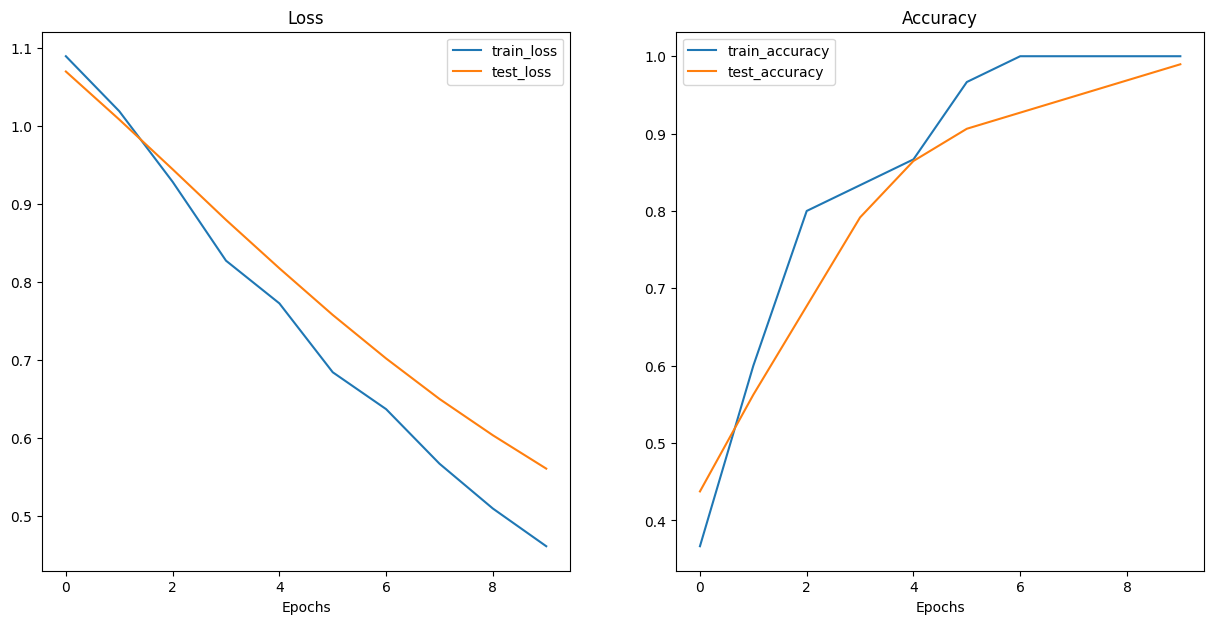

In [23]:
from modular.helper import plot_loss_curves


plot_loss_curves(effnetb2_results)

In [24]:
from modular.utils import save_model

# Save the model
save_model(model=effnetb2,
                 target_dir="models",
                 model_name="pretrained_effnetb2_feature_extractor_3_types_of_flowers_100%.pth")

[INFO] Saving model to: models/pretrained_effnetb2_feature_extractor_3_types_of_flowers_100%.pth


In [25]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_model_size = Path("models/pretrained_effnetb2_feature_extractor_3_types_of_flowers_100%.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_effnetb2_model_size} MB")

Pretrained EffNetB2 feature extractor model size: 29 MB


In [26]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [27]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.5604327619075775,
 'test_acc': 0.9895833333333334,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

### EfficientNet_B3

In [28]:
effnetb3 = torchvision.models.efficientnet_b3()
effnetb3.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1536, out_features=1000, bias=True)
)

In [29]:
def create_effnetb3_model(num_classes:int=3,
                          seed:int=42):

  weights = torchvision.models.EfficientNet_B3_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b3(weights=weights)

  for param in model.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1536, out_features=num_classes),
    )

  return model, transforms

In [30]:
effnetb3, effnetb3_transforms = create_effnetb3_model(num_classes=3,
                                                      seed=42)

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 199MB/s]


In [31]:
from torchinfo import summary

summary(effnetb3,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1536, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 40, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 40, 112, 112]    (1,080)              False
│    │    └─BatchNorm2d (1)                                  [1, 40, 112, 112]    [1, 40, 112, 112]    (80)                 False
│    │    └─SiLU (2)                                         [1, 40, 112, 112]    [1, 40, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 40, 112, 112]    [1, 2

In [32]:
from modular import data_setup
train_dataloader_effnetb3, test_dataloader_effnetb3, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb3_transforms,
                                                                                                 batch_size=32)

In [33]:
from modular import engine

optimizer = torch.optim.Adam(
    params=effnetb3.parameters(),
    lr=1e-3
)

loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
effnetb3_results = engine.train(
    model=effnetb3,
    train_dataloader=train_dataloader_effnetb3,
    test_dataloader=test_dataloader_effnetb3,
    epochs=10,
    optimizer=optimizer,
    loss_fn=loss_fn,
    device=device
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1300 | train_acc: 0.2333 | test_loss: 1.0473 | test_acc: 0.5000
Epoch: 2 | train_loss: 1.0156 | train_acc: 0.6000 | test_loss: 1.0023 | test_acc: 0.6146
Epoch: 3 | train_loss: 0.9469 | train_acc: 0.8000 | test_loss: 0.9562 | test_acc: 0.7604
Epoch: 4 | train_loss: 0.8664 | train_acc: 0.8667 | test_loss: 0.9087 | test_acc: 0.8333
Epoch: 5 | train_loss: 0.8202 | train_acc: 0.8667 | test_loss: 0.8619 | test_acc: 0.8958
Epoch: 6 | train_loss: 0.7091 | train_acc: 1.0000 | test_loss: 0.8133 | test_acc: 0.9167
Epoch: 7 | train_loss: 0.6651 | train_acc: 0.9667 | test_loss: 0.7664 | test_acc: 0.9167
Epoch: 8 | train_loss: 0.6119 | train_acc: 0.9667 | test_loss: 0.7222 | test_acc: 0.9479
Epoch: 9 | train_loss: 0.5279 | train_acc: 1.0000 | test_loss: 0.6819 | test_acc: 0.9479
Epoch: 10 | train_loss: 0.4923 | train_acc: 1.0000 | test_loss: 0.6424 | test_acc: 0.9479


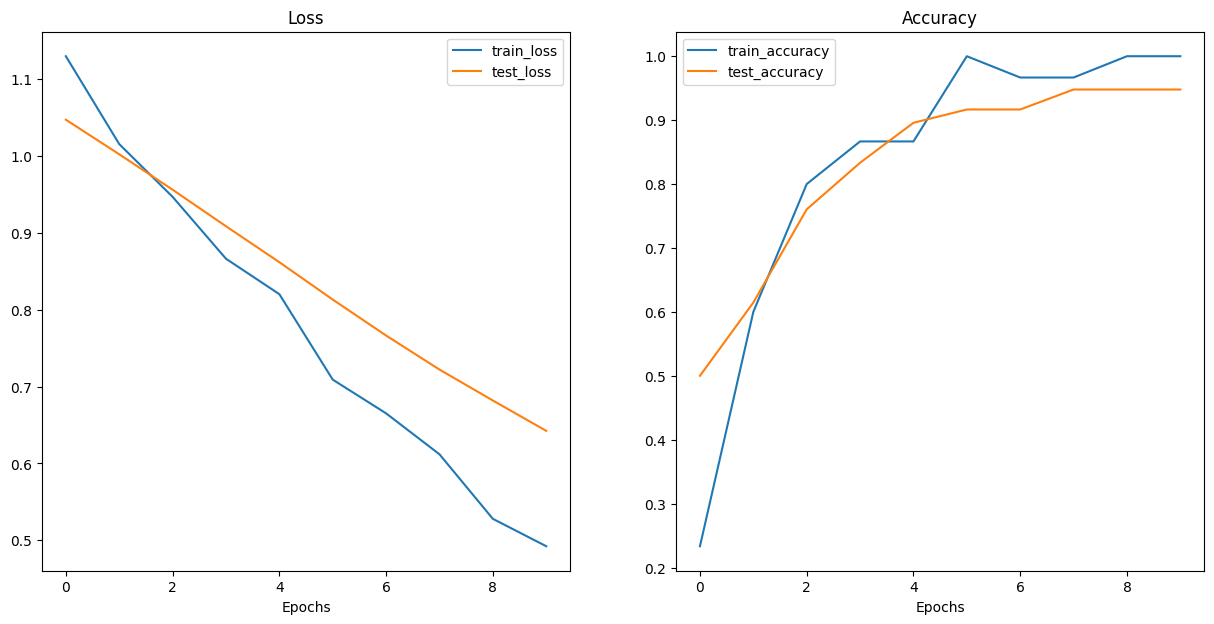

In [34]:
from modular.helper import plot_loss_curves

plot_loss_curves(effnetb3_results)

In [35]:
from modular import utils

utils.save_model(model=effnetb3,
                 target_dir="models",
                 model_name="pretrained_effnetb3_feature_extractor_3_types_of_flowers_100%.pth")

[INFO] Saving model to: models/pretrained_effnetb3_feature_extractor_3_types_of_flowers_100%.pth


In [36]:
from pathlib import Path

pretrained_effnetb3_model_size = Path("models/pretrained_effnetb3_feature_extractor_3_types_of_flowers_100%.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)

In [37]:
effnetb3_total_params = sum(torch.numel(param) for param in effnetb3.parameters())
effnetb3_total_params

10700843

In [38]:
effnetb3_stats = {"test_loss": effnetb3_results["test_loss"][-1],
                  "test_acc": effnetb3_results["test_acc"][-1],
                  "number_of_parameters": effnetb3_total_params,
                  "model_size (MB)": pretrained_effnetb3_model_size}
effnetb3_stats

{'test_loss': 0.642407218615214,
 'test_acc': 0.9479166666666666,
 'number_of_parameters': 10700843,
 'model_size (MB)': 41}

###classtorchvision.models.ViT_B_16_

In [39]:
# Check out ViT heads layer
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [40]:
def create_vit_model(num_classes:int=3,
                     seed:int=42):
    """Creates a ViT-B/16 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of target classes. Defaults to 3.
        seed (int, optional): random seed value for output layer. Defaults to 42.

    Returns:
        model (torch.nn.Module): ViT-B/16 feature extractor model.
        transforms (torchvision.transforms): ViT-B/16 image transforms.
    """
    # Create ViT_B_16 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all layers in model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head to suit our needs (this will be trainable)
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, # keep this the same as original model
                                          out_features=num_classes)) # update to reflect target number of classes

    return model, transforms

In [41]:
# Create ViT model and transforms
vit, vit_transforms = create_vit_model(num_classes=3,
                                       seed=42)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 121MB/s]


In [42]:
from torchinfo import summary

# # Print ViT feature extractor model summary (uncomment for full output)
summary(vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [43]:
# Setup ViT DataLoaders
from modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)

In [44]:
from modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Train ViT model with seeds set for reproducibility
set_seeds()
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=10,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.3501 | train_acc: 0.1333 | test_loss: 1.1374 | test_acc: 0.3333
Epoch: 2 | train_loss: 1.1669 | train_acc: 0.4000 | test_loss: 0.9927 | test_acc: 0.5521
Epoch: 3 | train_loss: 1.0061 | train_acc: 0.6000 | test_loss: 0.8687 | test_acc: 0.7083
Epoch: 4 | train_loss: 0.8657 | train_acc: 0.7667 | test_loss: 0.7627 | test_acc: 0.8021
Epoch: 5 | train_loss: 0.7438 | train_acc: 0.8000 | test_loss: 0.6725 | test_acc: 0.8229
Epoch: 6 | train_loss: 0.6386 | train_acc: 0.8667 | test_loss: 0.5963 | test_acc: 0.8958
Epoch: 7 | train_loss: 0.5486 | train_acc: 0.9333 | test_loss: 0.5322 | test_acc: 0.9479
Epoch: 8 | train_loss: 0.4722 | train_acc: 1.0000 | test_loss: 0.4783 | test_acc: 0.9792
Epoch: 9 | train_loss: 0.4078 | train_acc: 1.0000 | test_loss: 0.4329 | test_acc: 0.9896
Epoch: 10 | train_loss: 0.3539 | train_acc: 1.0000 | test_loss: 0.3941 | test_acc: 1.0000


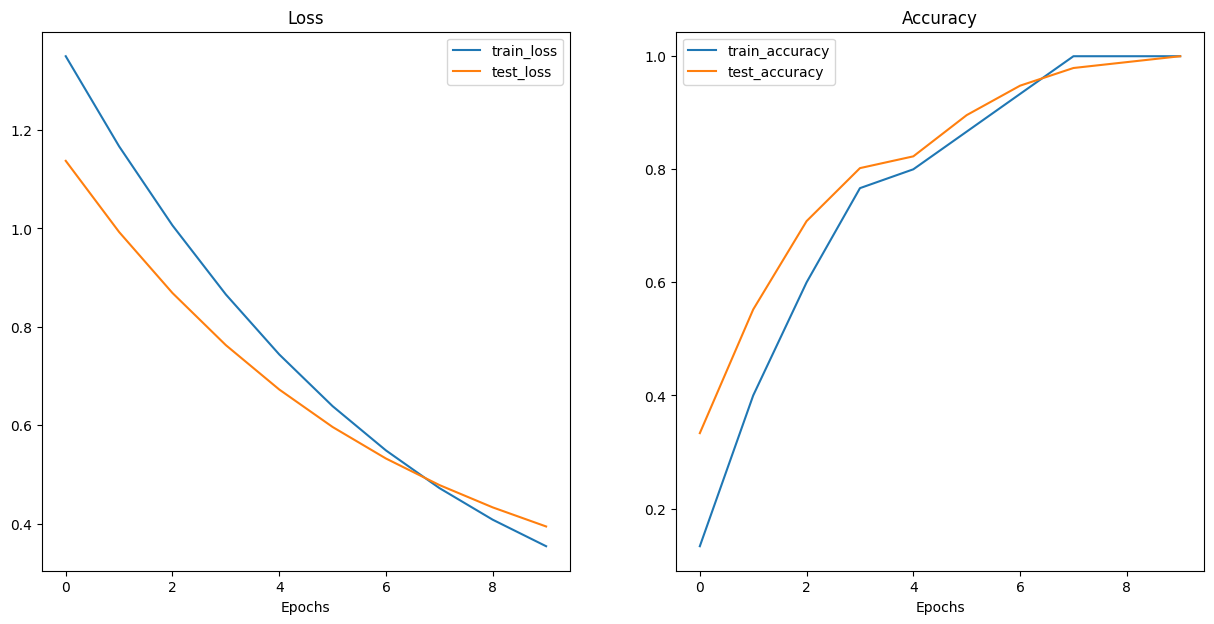

In [45]:
from modular.helper import plot_loss_curves

plot_loss_curves(vit_results)

In [46]:
# Save the model
from modular import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="pretrained_vit_feature_extractor_3_types_of_flowers.pth")

[INFO] Saving model to: models/pretrained_vit_feature_extractor_3_types_of_flowers.pth


In [47]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/pretrained_vit_feature_extractor_3_types_of_flowers.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


In [48]:
# Count number of parameters in ViT
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [49]:
# Create ViT statistics dictionary
vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}

vit_stats

{'test_loss': 0.3940851887067159,
 'test_acc': 1.0,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}

In [50]:
regnet = torchvision.models.regnet_y_128gf()
regnet.fc

Linear(in_features=7392, out_features=1000, bias=True)

In [51]:
def create_regnet_model(num_classes:int=3,
                         seed:int=42):

  weights = torchvision.models.RegNet_Y_128GF_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.regnet_y_128gf(weights=weights)

  for param in model.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)
  model.fc = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=7392, out_features=num_classes),
    )

  return model, transforms

In [52]:
regnet, regnet_transforms = create_regnet_model(num_classes=3,
                                                      seed=42)

Downloading: "https://download.pytorch.org/models/regnet_y_128gf_swag-c8ce3e52.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_128gf_swag-c8ce3e52.pth
100%|██████████| 2.40G/2.40G [00:32<00:00, 79.2MB/s]


In [53]:
from torchinfo import summary
summary(
    regnet,
    input_size=(1, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
RegNet (RegNet)                                              [1, 3, 224, 224]     [1, 3]               --                   Partial
├─SimpleStemIN (stem)                                        [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    └─Conv2d (0)                                            [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    └─BatchNorm2d (1)                                       [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    └─ReLU (2)                                              [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
├─Sequential (trunk_output)                                  [1, 32, 112, 112]    [1, 7392, 7, 7]      --                   False
│    └─AnyStage (block1)                                     [1, 32, 112, 112]    [1, 5

In [54]:
from modular import data_setup
train_dataloader_regnet, test_dataloader_regnet, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=regnet_transforms,
    batch_size=32
)

In [55]:
from modular import engine

optimizer = torch.optim.Adam(
    params=regnet.parameters(),
    lr=1e-3
)

loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
regnet_results = engine.train(
    model=regnet,
    train_dataloader=train_dataloader_regnet,
    test_dataloader=test_dataloader_regnet,
    epochs=10,
    optimizer=optimizer,
    loss_fn=loss_fn,
    device=device)



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2309 | train_acc: 0.2333 | test_loss: 0.7364 | test_acc: 0.6458
Epoch: 2 | train_loss: 0.6717 | train_acc: 0.6667 | test_loss: 0.5677 | test_acc: 0.8229
Epoch: 3 | train_loss: 0.2598 | train_acc: 0.9667 | test_loss: 0.5350 | test_acc: 0.6667
Epoch: 4 | train_loss: 0.1647 | train_acc: 1.0000 | test_loss: 0.3661 | test_acc: 0.8438
Epoch: 5 | train_loss: 0.0757 | train_acc: 1.0000 | test_loss: 0.2305 | test_acc: 0.9375
Epoch: 6 | train_loss: 0.0324 | train_acc: 1.0000 | test_loss: 0.1560 | test_acc: 0.9896
Epoch: 7 | train_loss: 0.0121 | train_acc: 1.0000 | test_loss: 0.1149 | test_acc: 1.0000
Epoch: 8 | train_loss: 0.0128 | train_acc: 1.0000 | test_loss: 0.0892 | test_acc: 1.0000
Epoch: 9 | train_loss: 0.0065 | train_acc: 1.0000 | test_loss: 0.0725 | test_acc: 1.0000
Epoch: 10 | train_loss: 0.0051 | train_acc: 1.0000 | test_loss: 0.0621 | test_acc: 1.0000


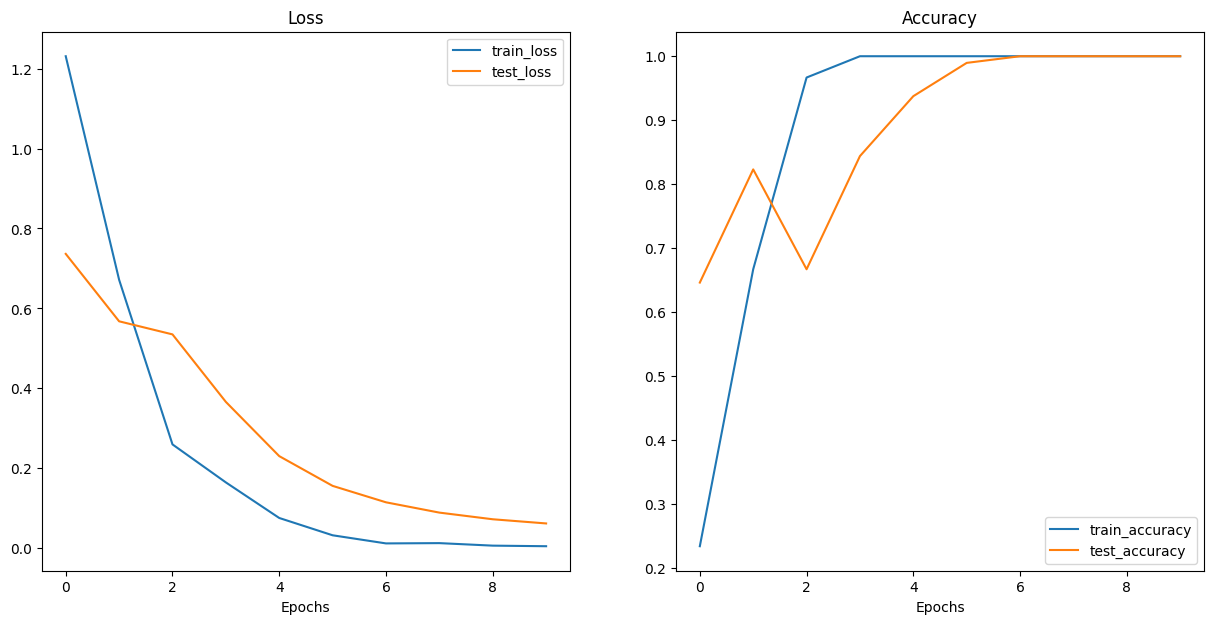

In [56]:
from modular.helper import plot_loss_curves

plot_loss_curves(regnet_results)

In [57]:
from modular import utils

utils.save_model(model=regnet,
                 target_dir="models",
                 model_name="pretrained_regnet_feature_extractor_3_types_of_flowers.pth")

[INFO] Saving model to: models/pretrained_regnet_feature_extractor_3_types_of_flowers.pth


In [58]:
from pathlib import Path
pretrained_regnet_model_size = Path("models/pretrained_regnet_feature_extractor_3_types_of_flowers.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained RegNet feature extractor model size: {pretrained_regnet_model_size} MB")

Pretrained RegNet feature extractor model size: 2433 MB


In [59]:
regnet_total_params = sum(torch.numel(param) for param in regnet.parameters())
regnet_total_params

637442073

In [60]:
regnet_stats = {
    "test_loss": regnet_results["test_loss"][-1],
    "test_acc": regnet_results["test_acc"][-1],
    "number_of_parameters": regnet_total_params,
    "model_size (MB)": pretrained_regnet_model_size
}
regnet_stats

{'test_loss': 0.062066044037540756,
 'test_acc': 1.0,
 'number_of_parameters': 637442073,
 'model_size (MB)': 2433}

In [61]:
from pathlib import Path

# Get all test data paths
print(f"[INFO] Finding all filepaths ending with '.png' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[INFO] Finding all filepaths ending with '.png' in directory: data/3_types_of_flowers_100%/test


[PosixPath('data/3_types_of_flowers_100%/test/hard-leaved pocket orchid/44.jpg'),
 PosixPath('data/3_types_of_flowers_100%/test/hard-leaved pocket orchid/57.jpg'),
 PosixPath('data/3_types_of_flowers_100%/test/hard-leaved pocket orchid/24.jpg'),
 PosixPath('data/3_types_of_flowers_100%/test/hard-leaved pocket orchid/40.jpg'),
 PosixPath('data/3_types_of_flowers_100%/test/hard-leaved pocket orchid/22.jpg')]

In [62]:
from modular.utils import pred_and_store

# Make predictions across test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu") # make predictions on CPU

  0%|          | 0/80 [00:00<?, ?it/s]

In [63]:
# Inspect the first 2 prediction dictionaries
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('data/3_types_of_flowers_100%/test/hard-leaved pocket orchid/44.jpg'),
  'class_name': 'hard-leaved pocket orchid',
  'pred_prob': 0.7726,
  'pred_class': 'hard-leaved pocket orchid',
  'time_for_pred': 0.4372,
  'correct': True},
 {'image_path': PosixPath('data/3_types_of_flowers_100%/test/hard-leaved pocket orchid/57.jpg'),
  'class_name': 'hard-leaved pocket orchid',
  'pred_prob': 0.7153,
  'pred_class': 'hard-leaved pocket orchid',
  'time_for_pred': 0.1119,
  'correct': True}]

In [64]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/3_types_of_flowers_100%/test/hard-leaved ...,hard-leaved pocket orchid,0.7726,hard-leaved pocket orchid,0.4372,True
1,data/3_types_of_flowers_100%/test/hard-leaved ...,hard-leaved pocket orchid,0.7153,hard-leaved pocket orchid,0.1119,True
2,data/3_types_of_flowers_100%/test/hard-leaved ...,hard-leaved pocket orchid,0.7568,hard-leaved pocket orchid,0.1035,True
3,data/3_types_of_flowers_100%/test/hard-leaved ...,hard-leaved pocket orchid,0.7340,hard-leaved pocket orchid,0.1053,True
4,data/3_types_of_flowers_100%/test/hard-leaved ...,hard-leaved pocket orchid,0.5610,hard-leaved pocket orchid,0.0956,True


In [65]:
# Check number of correct predictions
effnetb2_test_pred_df.correct.value_counts()

,count
correct,
True,79
False,1


In [66]:
# Find the average time per prediction
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred} seconds")

EffNetB2 average time per prediction: 0.1034 seconds


In [67]:
# Add EffNetB2 average prediction time to stats dictionary
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.5604327619075775,
 'test_acc': 0.9895833333333334,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29,
 'time_per_pred_cpu': np.float64(0.1034)}

### Predictions of effnetb3

In [68]:
effnetb3_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb3,
                                          transform=effnetb3_transforms,
                                          class_names=class_names,
                                          device="cpu")

import pandas as pd
effnetb3_test_pred_df = pd.DataFrame(effnetb3_test_pred_dicts)
effnetb3_test_pred_df.head()
effnetb3_test_pred_df.correct.value_counts()

effnetb3_average_time_per_pred = round(effnetb3_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB3 average time per prediction: {effnetb3_average_time_per_pred} seconds")

effnetb3_stats["time_per_pred_cpu"] = effnetb3_average_time_per_pred
effnetb3_stats

  0%|          | 0/80 [00:00<?, ?it/s]

EffNetB3 average time per prediction: 0.1542 seconds


{'test_loss': 0.642407218615214,
 'test_acc': 0.9479166666666666,
 'number_of_parameters': 10700843,
 'model_size (MB)': 41,
 'time_per_pred_cpu': np.float64(0.1542)}

### Predictions of vit

In [69]:
# Make list of prediction dictionaries with ViT feature extractor model on test images
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu")

  0%|          | 0/80 [00:00<?, ?it/s]

In [70]:
# Check the first couple of ViT predictions on the test dataset
vit_test_pred_dicts[:2]

[{'image_path': PosixPath('data/3_types_of_flowers_100%/test/hard-leaved pocket orchid/44.jpg'),
  'class_name': 'hard-leaved pocket orchid',
  'pred_prob': 0.6177,
  'pred_class': 'hard-leaved pocket orchid',
  'time_for_pred': 0.6884,
  'correct': True},
 {'image_path': PosixPath('data/3_types_of_flowers_100%/test/hard-leaved pocket orchid/57.jpg'),
  'class_name': 'hard-leaved pocket orchid',
  'pred_prob': 0.8544,
  'pred_class': 'hard-leaved pocket orchid',
  'time_for_pred': 0.5136,
  'correct': True}]

In [71]:
# Turn vit_test_pred_dicts into a DataFrame
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/3_types_of_flowers_100%/test/hard-leaved ...,hard-leaved pocket orchid,0.6177,hard-leaved pocket orchid,0.6884,True
1,data/3_types_of_flowers_100%/test/hard-leaved ...,hard-leaved pocket orchid,0.8544,hard-leaved pocket orchid,0.5136,True
2,data/3_types_of_flowers_100%/test/hard-leaved ...,hard-leaved pocket orchid,0.8874,hard-leaved pocket orchid,0.5436,True
3,data/3_types_of_flowers_100%/test/hard-leaved ...,hard-leaved pocket orchid,0.9083,hard-leaved pocket orchid,0.5310,True
4,data/3_types_of_flowers_100%/test/hard-leaved ...,hard-leaved pocket orchid,0.8574,hard-leaved pocket orchid,0.5399,True


In [72]:
# Count the number of correct predictions
vit_test_pred_df.correct.value_counts()

,count
correct,
True,80


In [73]:
# Calculate average time per prediction for ViT model
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred} seconds")

ViT average time per prediction: 0.4002 seconds


In [74]:
# Add average prediction time for ViT model on CPU
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.3940851887067159,
 'test_acc': 1.0,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327,
 'time_per_pred_cpu': np.float64(0.4002)}

### Predictions of Regnet

In [75]:
regnet_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=regnet,
                                     transform=regnet_transforms,
                                     class_names=class_names,
                                     device="cpu")

import pandas as pd
regnet_test_pred_df = pd.DataFrame(regnet_test_pred_dicts)
regnet_test_pred_df.head()

regnet_test_pred_df.correct.value_counts()

regnet_average_time_per_pred = round(regnet_test_pred_df.time_for_pred.mean(), 4)
print(f"RegNet average time per prediction: {regnet_average_time_per_pred} seconds")

regnet_stats["time_per_pred_cpu"] = regnet_average_time_per_pred
regnet_stats



  0%|          | 0/80 [00:00<?, ?it/s]

RegNet average time per prediction: 8.9641 seconds


{'test_loss': 0.062066044037540756,
 'test_acc': 1.0,
 'number_of_parameters': 637442073,
 'model_size (MB)': 2433,
 'time_per_pred_cpu': np.float64(8.9641)}

In [76]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, effnetb3_stats, vit_stats, regnet_stats])

# Add column for model names
df["model"] = ["EffNetB2", "EffNetB3", "ViT", "RegNet"]

# Convert accuracy to percentages
df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.560433,98.96,7705221,29,0.1034,EffNetB2
1,0.642407,94.79,10700843,41,0.1542,EffNetB3
2,0.394085,100.00,85800963,327,0.4002,ViT
3,0.062066,100.00,637442073,2433,8.9641,RegNet


In [ ]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]), # divide ViT statistics by EffNetB2 statistics
             columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,1.255199,1.010509,11.135432,11.275862,4.407186


In [77]:
!mkdir images/

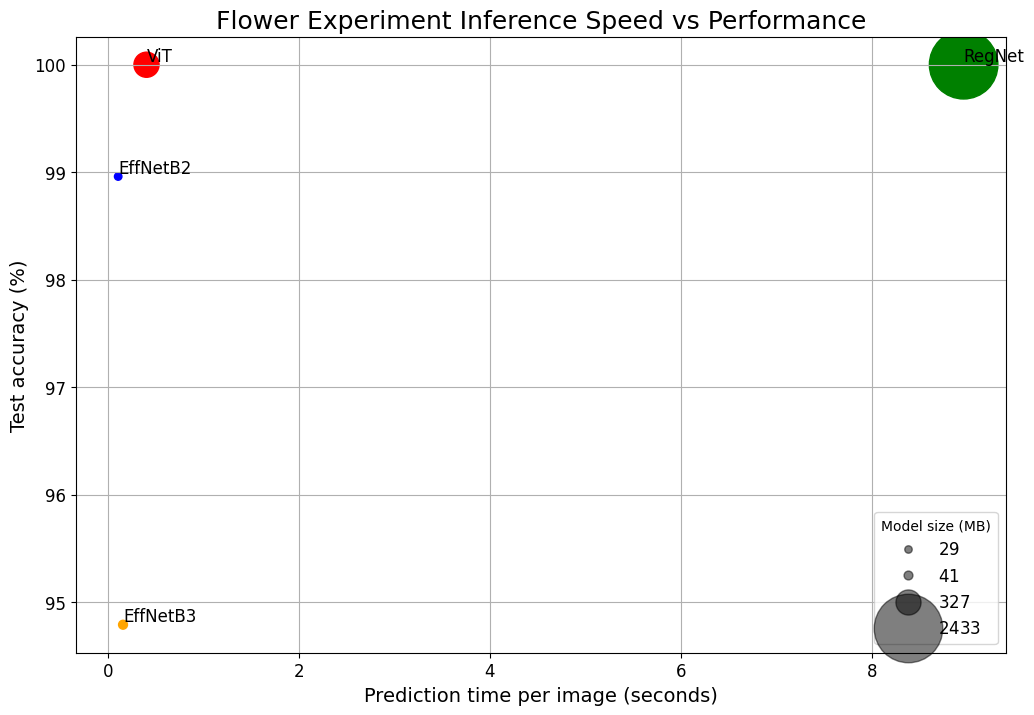

In [78]:
# 1. Create a plot from model comparison DataFrame
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df,
                     x="time_per_pred_cpu",
                     y="test_acc",
                     c=["blue", "orange", "red", "green"], # what colours to use?
                     s="model_size (MB)") # size the dots by the model sizes

# 2. Add titles, labels and customize fontsize for aesthetics
ax.set_title("Flower Experiment Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

# 3. Annotate with model names
for index, row in df.iterrows():
    ax.annotate(text=row["model"], # note: depending on your version of Matplotlib, you may need to use "s=..." or "text=...", see: https://github.com/faustomorales/keras-ocr/issues/183#issuecomment-977733270
                xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03),
                size=12)

# 4. Create a legend based on model sizes
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc="lower right",
                              title="Model size (MB)",
                              fontsize=12)

# Save the figure
plt.savefig("images/flower-inference-speed-vs-performance.jpg")

# Show the figure
plt.show()

In [ ]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 108.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.8 MB/s eta 0:00:00
Gradio version: 5.23.3


In [ ]:
# Put EffNetB2 on CPU
effnetb2.to("cpu")

# Check the device
next(iter(effnetb2.parameters())).device

device(type='cpu')

In [ ]:
from typing import Tuple, Dict
from time import time


def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = time()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(time() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

In [ ]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: data/3_types_of_flowers_100%/test/canterbury bells/78.jpg

Prediction label and probability dictionary: 
{'canterbury bells': 0.6758814454078674, 'hard-leaved pocket orchid': 0.12626856565475464, 'pink primrose': 0.19784991443157196}
Prediction time: 0.29189 seconds


In [ ]:
# Create a list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data/3_types_of_flowers_100%/test/hard-leaved pocket orchid/41.jpg'],
 ['data/3_types_of_flowers_100%/test/hard-leaved pocket orchid/37.jpg'],
 ['data/3_types_of_flowers_100%/test/canterbury bells/77.jpg']]

In [ ]:
import gradio as gr

# Create title, description and article strings
title = "Flower Classification"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of flowers as 'pink primrose', 'hard-leaved pocket orchid', 'canterbury bells'"
article = "Created as a part of personal projects"

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL?

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a2511b3225d89e825a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import shutil
from pathlib import Path

# Create FoodVision mini demo path
flower_mini_demo_path = Path("demos/flower_classification_mini/")

# Remove files that might already exist there and create new directory
if flower_mini_demo_path.exists():
    shutil.rmtree(flower_mini_demo_path)
# If the file doesn't exist, create it anyway
flower_mini_demo_path.mkdir(parents=True,
                                exist_ok=True)

# Check what's in the folder
!ls demos/flower_classification_mini/

In [ ]:
import shutil
from pathlib import Path

# 1. Create an examples directory
flower_mini_examples_path = flower_mini_demo_path / "examples"
flower_mini_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths
flower_mini_examples = [Path('data/3_types_of_flowers_100%/test/hard-leaved pocket orchid/20.jpg'),
                            Path('data/3_types_of_flowers_100%/test/canterbury bells/60.jpg'),
                            Path('data/3_types_of_flowers_100%/test/pink primrose/0.jpg')]

# 3. Copy the three random images to the examples directory
for example in flower_mini_examples:
    destination = flower_mini_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

[INFO] Copying data/3_types_of_flowers_100%/test/hard-leaved pocket orchid/20.jpg to demos/flower_classification_mini/examples/20.jpg
[INFO] Copying data/3_types_of_flowers_100%/test/canterbury bells/60.jpg to demos/flower_classification_mini/examples/60.jpg
[INFO] Copying data/3_types_of_flowers_100%/test/pink primrose/0.jpg to demos/flower_classification_mini/examples/0.jpg


In [ ]:
import os

# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(flower_mini_examples_path)]
example_list

[['examples/0.jpg'], ['examples/60.jpg'], ['examples/20.jpg']]

In [ ]:
import shutil

# Create a source path for our target model
effnetb2_flower_mini_model_path = "models/pretrained_effnetb2_feature_extractor_3_types_of_flowers_100%.pth"

# Create a destination path for our target model
effnetb2_flower_mini_model_destination = flower_mini_demo_path / effnetb2_flower_mini_model_path.split("/")[1]

# Try to move the file
try:
    print(f"[INFO] Attempting to move {effnetb2_flower_mini_model_path} to {effnetb2_flower_mini_model_destination}")

    # Move the model
    shutil.move(src=effnetb2_flower_mini_model_path,
                dst=effnetb2_flower_mini_model_destination)

    print(f"[INFO] Model move complete.")

# If the model has already been moved, check if it exists
except:
    print(f"[INFO] No model found at {effnetb2_flower_mini_model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {effnetb2_flower_mini_model_destination}: {effnetb2_flower_mini_model_destination.exists()}")

[INFO] Attempting to move models/pretrained_effnetb2_feature_extractor_3_types_of_flowers_100%.pth to demos/flower_classification_mini/pretrained_effnetb2_feature_extractor_3_types_of_flowers_100%.pth
[INFO] Model move complete.


In [ ]:
%%writefile demos/flower_classification_mini/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

Writing demos/flower_classification_mini/model.py


In [ ]:
%%writefile demos/flower_classification_mini/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ["pink primrose", "hard-leaved pocket orchid", "canterbury bells"]

### 2. Model and transforms preparation ###

# Create EffNetB2 model
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=3, # len(class_names) would also work
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="pretrained_effnetb2_feature_extractor_3_types_of_flowers.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "Flower Classification"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of 'pink primrose', 'hard-leaved pocket orchid','canterbury bells'"
article = ""

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    # Create examples list from "examples/" directory
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

Writing demos/flower_classification_mini/app.py


In [ ]:
print(torch.__version__)
print(torchvision.__version__)
print(gr.__version__)

2.6.0+cu124
0.21.0+cu124
5.23.3


In [ ]:
%%writefile demos/flower_classification_mini/requirements.txt
torch==2.6.0
torchvision==0.21.0
gradio==5.23.3

Writing demos/flower_classification_mini/requirements.txt


In [ ]:
# Change into and then zip the foodvision_mini folder but exclude certain files
!cd demos/flower_classification_mini && zip -r ../flower_classification_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped flower classification mini app
try:
    from google.colab import files
    files.download("demos/flower_classification_mini.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download(), please manually download.")

  adding: app.py (deflated 58%)
  adding: examples/ (stored 0%)
  adding: examples/0.jpg (deflated 0%)
  adding: examples/60.jpg (deflated 0%)
  adding: examples/20.jpg (deflated 1%)
  adding: model.py (deflated 55%)
  adding: pretrained_effnetb2_feature_extractor_3_types_of_flowers_100%.pth (deflated 8%)
  adding: requirements.txt (deflated 4%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# !git clone https://github.com/Keisuke-Miyata/Flower102_Classification_mini.git